# EDUNET FOUNDATION-Class Exercise Notebook

## LAB 1 - Demonstrating Support Vector Machine

# <b><u> Support Vector Machines </b>

### Support Vector Machines (SVMs in short) are machine learning algorithms that are used for classification and regression purposes. SVMs are one of the powerful machine learning algorithms for classification, regression and outlier detection purposes. An SVM classifier builds a model that assigns new data points to one of the given categories. Thus, it can be viewed as a non-probabilistic binary linear classifier.

### SVMs can be used for linear classification purposes. In addition to performing linear classification, SVMs can efficiently perform a non-linear classification using the kernel trick. It enable us to implicitly map the inputs into high dimensional feature spaces.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns
sns.set()

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [3]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
#pip install --upgrade scikit-learn
# pip install scikit-learn==0.21.3

In [5]:
from sklearn.datasets import make_blobs

## <b>Motivation behind Support Vector Machines</b>

### Earlier we understood the concept of Bayesian classification, where we learned a simple model describing the distribution of each underlying class, and used these generative models to probabilistically determine labels for new points.

### That was an example of **generative classification**; here we will consider instead **discriminative classification**: rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

### As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

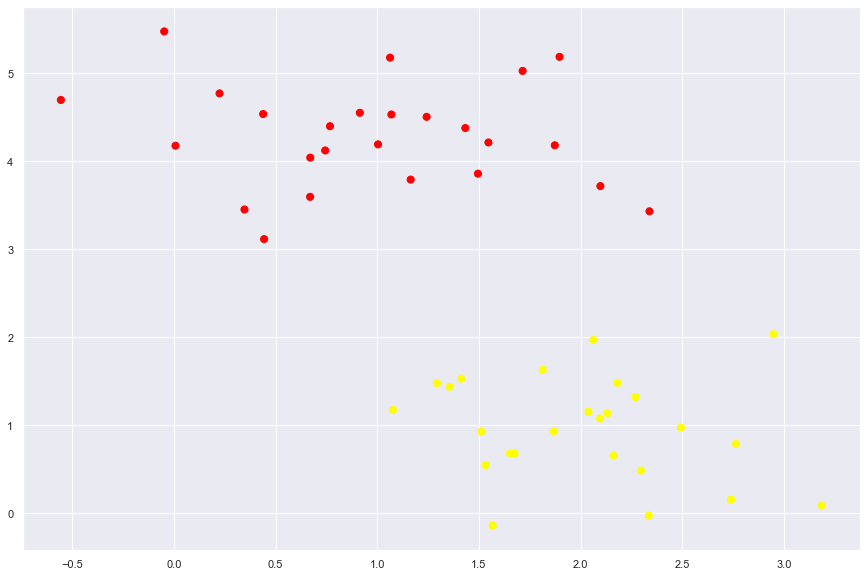

In [6]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

### A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.For two dimensional data like that shown here, this is a task we could do by hand. But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

### We can draw them as follows:

(-1.0, 3.5)

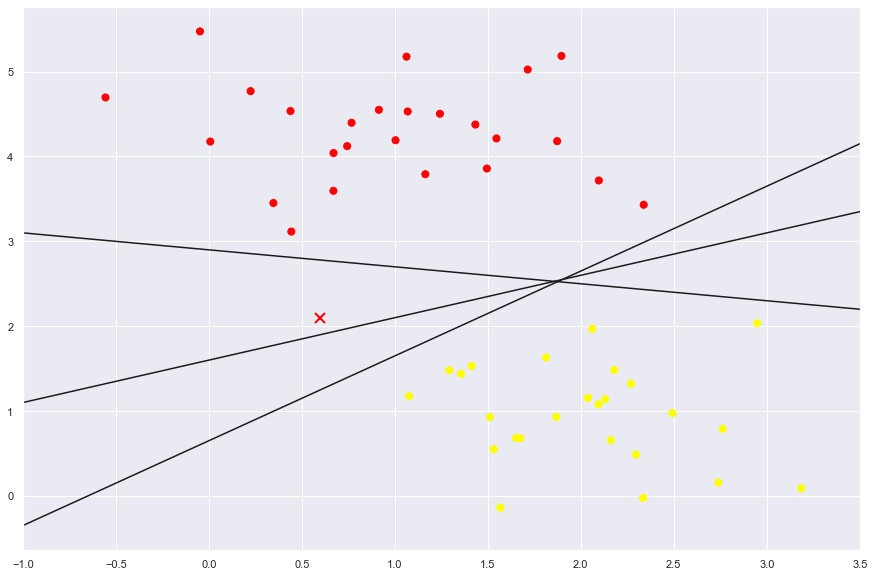

In [7]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5)

### These are three *very* different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label! Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## <b><u>Support Vector Machines: Maximizing the *Margin*</u></b>

### Support vector machines offer one way to improve on this.The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.Here is an example of how this might look:

(-1.0, 3.5)

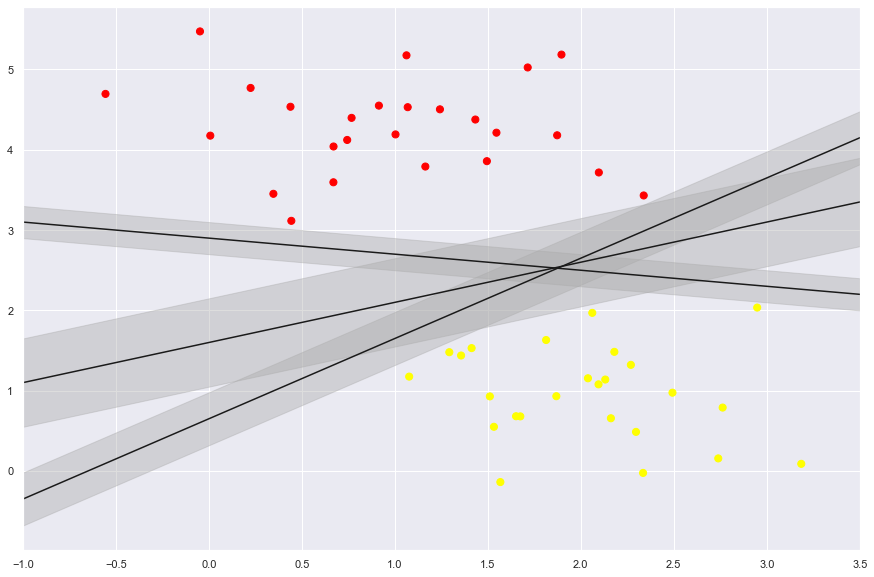

In [8]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5)

### In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. Support vector machines are an example of such a *maximum margin* estimator.

## <b>Fitting a support vector machine</b>

### Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data. For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [9]:
from sklearn.svm import SVC #Support vector classifier
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

### To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [10]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300,marker='o', linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

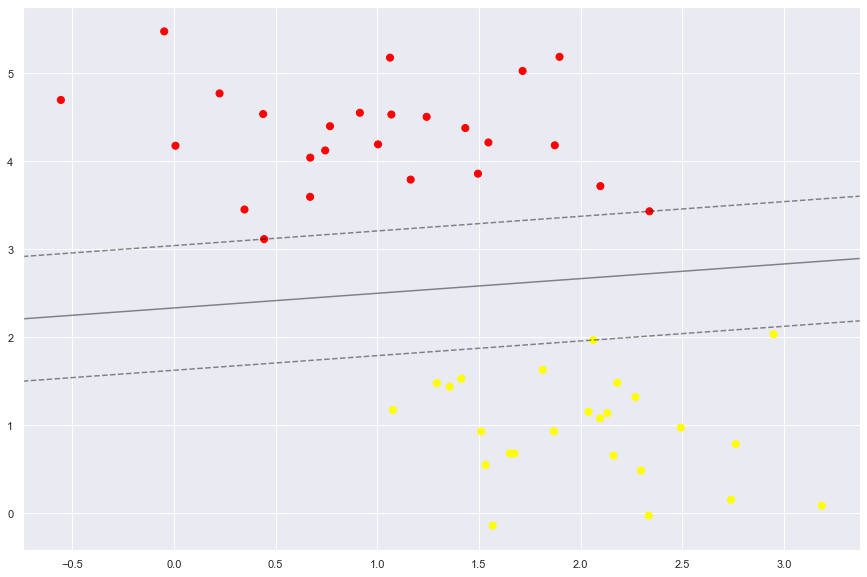

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)

### This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure. These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.

### In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [12]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

### A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

### We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

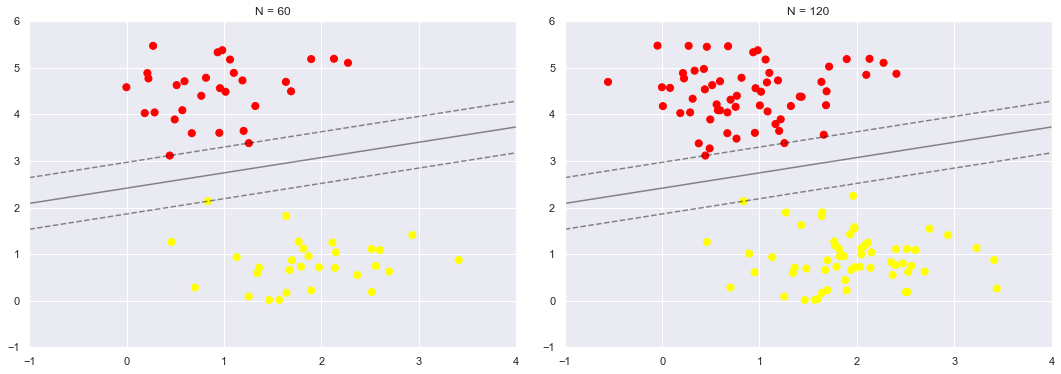

In [13]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50,marker='o', cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

### In the left panel, we see the model and the support vectors for 60 training points.In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.

### This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

In [14]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None))

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

<function __main__.plot_svm(N=10, ax=None)>

## <b> Beyond linear boundaries: Kernel SVM </b>

### Where SVM becomes extremely powerful is when it is combined with *kernels*.We have seen a version of kernels before, in the basis function of linear regressions. There we projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

### In SVM models, we can use a version of the same idea. To motivate the need for kernels, let's look at some data that is not linearly separable:

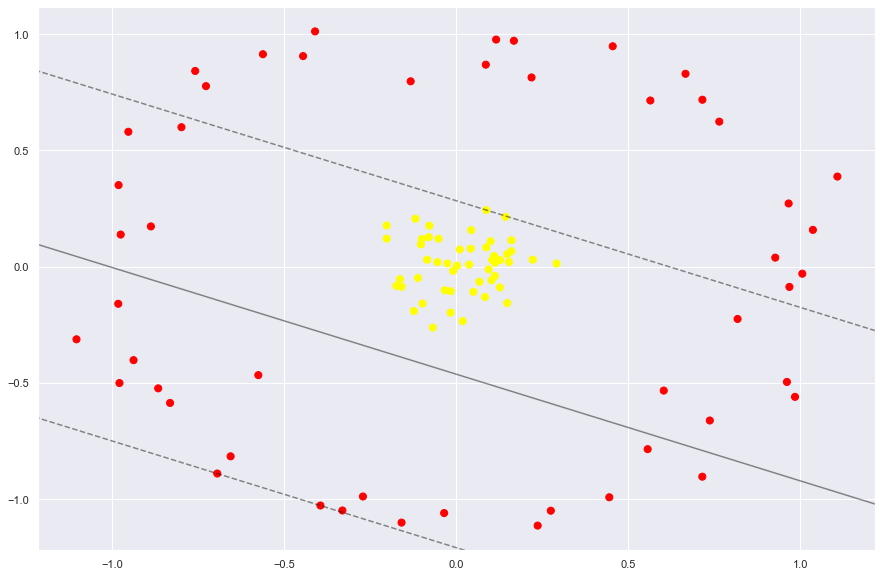

In [15]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False)

### It is clear that no linear discrimination will *ever* be able to separate this data.But we can draw a lesson from the basis function regressions, and think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.

### For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [16]:
X

array([[-0.0838553 ,  0.03024177],
       [-0.75763348,  0.84182803],
       [-0.79758434,  0.59999446],
       [ 0.08430243, -0.13011697],
       [ 0.019298  , -0.23392154],
       [ 0.71603112,  0.71804175],
       [ 0.08669298,  0.86889904],
       [-0.20139418,  0.1206463 ],
       [-0.56088694,  0.91376197],
       [-1.10252575, -0.312186  ],
       [ 0.10060383,  0.10938484],
       [ 0.0682533 , -0.06472843],
       [ 0.16825423,  0.97173991],
       [ 0.275579  , -1.04934372],
       [-0.951836  ,  0.58021413],
       [ 0.76509052,  0.62391274],
       [-0.12220035, -0.19072533],
       [-0.57423617, -0.4662312 ],
       [ 0.8181824 , -0.22476887],
       [ 0.00318781,  0.00471639],
       [ 0.96883567, -0.08693756],
       [ 0.10519656,  0.02938408],
       [-0.07911591,  0.12709864],
       [ 0.11281668, -0.03975561],
       [-0.65475528, -0.81543863],
       [ 0.98502727, -0.5597872 ],
       [-0.05390651,  0.01958334],
       [-0.02508959,  0.01381517],
       [ 0.14900899,

In [17]:
1.06909564e-01**2 +  1.09777740e+00**2

1.2165448748254302

In [18]:
(X ** 2).sum(1)

array([7.94627572e-03, 1.28268294e+00, 9.96134129e-01, 2.40373265e-02,
       5.50917008e-02, 1.02828451e+00, 7.62501222e-01, 5.51151440e-02,
       1.14955510e+00, 1.31302314e+00, 2.20861757e-02, 8.84828179e-03,
       9.72587938e-01, 1.17706603e+00, 1.24264020e+00, 9.74630607e-01,
       5.13090769e-02, 5.47118706e-01, 7.19943476e-01, 3.24064744e-05,
       9.46200686e-01, 1.19297399e-02, 2.24133910e-02, 1.43081125e-02,
       1.09364463e+00, 1.28364043e+00, 3.28941917e-03, 8.20346339e-04,
       4.66380636e-02, 2.41249457e-02, 1.03321811e+00, 9.14109279e-03,
       1.42149416e-02, 7.10673840e-01, 1.54552700e-03, 1.13337632e-02,
       6.52988706e-01, 6.48242456e-01, 1.23603536e+00, 1.20985330e+00,
       3.44449583e-02, 6.65972495e-02, 5.07518856e-02, 9.81475778e-01,
       7.20033905e-02, 1.02220306e+00, 2.50844404e-02, 2.40202431e-02,
       1.32791962e-02, 9.67893105e-01, 1.41656777e-02, 1.95485293e-02,
       3.89930247e-02, 1.17026982e+00, 3.98683605e-04, 8.29942433e-01,
      

In [19]:
r = np.exp(-(X ** 2).sum(1))

In [20]:
np.exp(-1.216)

0.2964134525853191

In [21]:
r

array([0.99208521, 0.27729234, 0.36930437, 0.97624927, 0.94639836,
       0.35761993, 0.46649815, 0.94637617, 0.31677767, 0.26900558,
       0.97815594, 0.99119075, 0.37810326, 0.30818161, 0.28862119,
       0.37733171, 0.94998501, 0.57861457, 0.48677977, 0.99996759,
       0.38821317, 0.98814114, 0.97783592, 0.98579376, 0.33499334,
       0.27702696, 0.99671599, 0.99917999, 0.95443278, 0.97616373,
       0.35585992, 0.99090056, 0.98588561, 0.49131302, 0.99845567,
       0.98873022, 0.52048786, 0.5229641 , 0.2905338 , 0.29824103,
       0.96614152, 0.93557193, 0.95051448, 0.37475763, 0.93052774,
       0.3598014 , 0.97522756, 0.97626595, 0.98680858, 0.37988257,
       0.98593418, 0.9806413 , 0.96175742, 0.31028321, 0.9996014 ,
       0.43607439, 0.32508849, 0.99214139, 0.28021628, 0.42226871,
       0.37225136, 0.396225  , 0.96389572, 0.36487123, 0.98554284,
       0.36294064, 0.36143431, 0.44235842, 0.32203296, 0.98562422,
       0.25195335, 0.98547004, 0.33266731, 0.93519152, 0.97359

### We can visualize this extra data dimension using a three-dimensional plot—if you are running this notebook live, you will be able to use the sliders to rotate the plot:

In [22]:
from mpl_toolkits import mplot3d
from ipywidgets import interact, interactive, fixed, interact_manual

Text(0.5, 0, 'r')

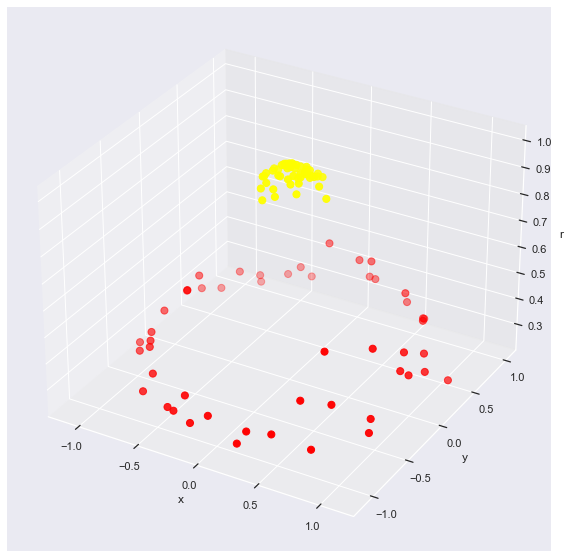

In [23]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r')

### We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

### Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results. In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

### One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

### A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large. However, because of a neat little procedure known as the *kernel trick*, a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

### $K(x_i,x_j)=(a⟨x_i,x_j⟩+b)^n $

### In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [24]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

In [25]:
clf.support_vectors_

array([[-0.57423617, -0.4662312 ],
       [-0.13162826,  0.79728458],
       [ 0.60368037, -0.53274053],
       [ 0.56480422,  0.71479971],
       [ 0.92768084,  0.03900869],
       [-0.88635849,  0.173215  ],
       [-0.20142879,  0.17728461],
       [-0.06732753, -0.26177057],
       [ 0.29234869,  0.0134963 ]])

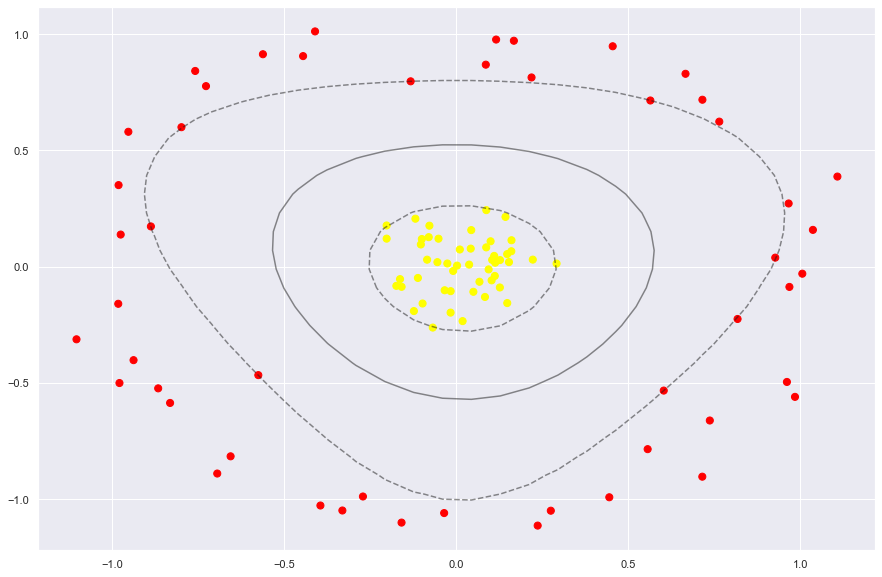

In [26]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none')

### Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

## <b> Tuning the SVM: Softening Margins </b>

### Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.But what if your data has some amount of overlap? For example, you may have data like this:

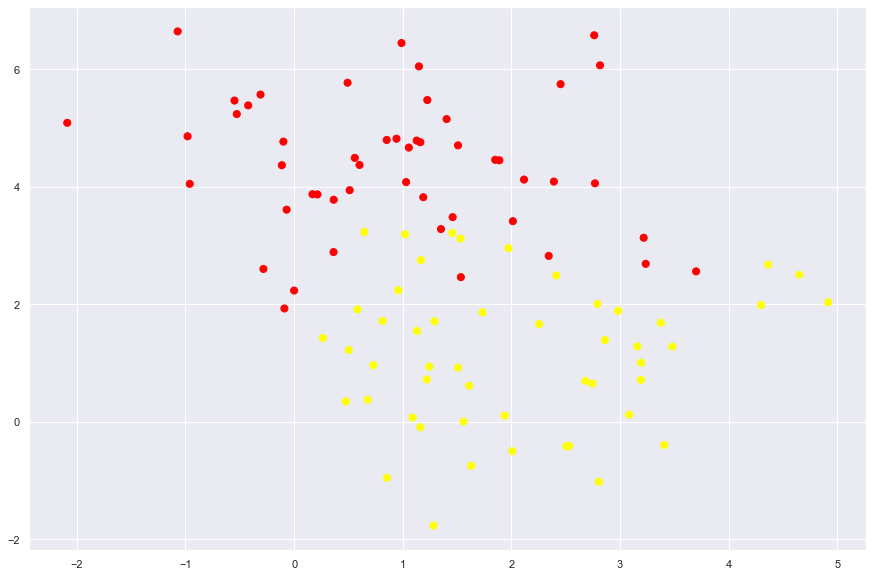

In [27]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

### To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.The hardness of the margin is controlled by a tuning parameter, most often known as $C$. For very large $C$, the margin is hard, and points cannot lie in it. For smaller $C$, the margin is softer, and can grow to encompass some points.

### The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

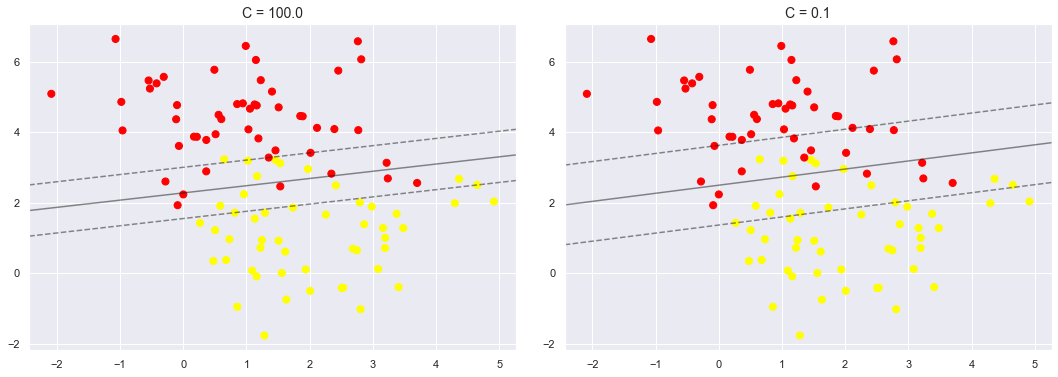

In [28]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [100.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

### The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation.

## <b> Objective function </b>>

### Support vector machine (SVM) is one of the most popular classification techniques in machine learning. Let's introduce the objective function of SVM through the logistic regression cost function *log loss* with l2 regularization:

### $J(\theta)=\frac{1}{m}\sum^{m}_{i=1}[y^{(i)}(-log(\hat{p}^{(i)}))+(1-y^{(i)})(-log(1-\hat{p}^{(i)}))] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_j^2$

### where 

### $\hat{p}^{(i)}=\sigma({\theta}^{T}\cdot {x}^{(i)})=1/(1+e^{-{\theta}^{T}\cdot {x}^{(i)}})$
<br>

### One way to interpret the cost function is that, if $y^{(i)}=1$, the loss contributed by this sample to $J(\theta)$ is $-log(\hat{p}^{(i)})$. On the other hand, if $y^{(i)}=0$, the loss contributed by this sample to $J(\theta)$ is $-log(1-\hat{p}^{(i)})$. 

<br>

### In **SVM**, we replace the individual loss $-log(\hat{p}^{(i)})$ with $max(0, 1-{\theta}^{T}\cdot{x}^{(i)})$, and $-log(1-\hat{p}^{(i)})$ with $max(0, 1+{\theta}^{T}\cdot{x}^{(i)})$. Let's define $z = {\theta}^{T}\cdot {x}^{(i)}$,and plot the individual loss as a function of z and see what they look like:

In [29]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

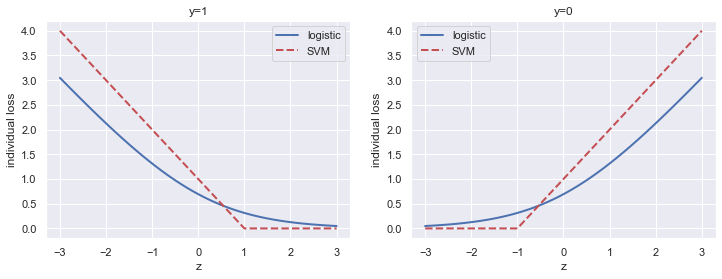

In [30]:
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
z = np.linspace(-3,3,num=100)
ax[0].plot(z,-np.log(sigmoid(z)),label='logistic',lw=2, color='b')
ax[1].plot(z,-np.log(1-sigmoid(z)),label='logistic',lw=2,color='b')
ax[0].plot(z,np.maximum(0,1-z),label='SVM',lw=2, color='r',linestyle='--')
ax[1].plot(z,np.maximum(0,1+z),label='SVM',lw=2,color='r',linestyle='--')
ax[0].set_title('y=1')
ax[1].set_title('y=0')
ax[0].set_xlabel('z')
ax[1].set_xlabel('z')
ax[0].set_ylabel('individual loss')
ax[1].set_ylabel('individual loss')
ax[0].legend()
ax[1].legend()
plt.show()

### As you can see, in both logistic regression and SVM, small z is penalized if $y=1$, and large z is penalized if $y=0$. **What's different is that for SVM, if $z < -1$ for $y=0$ and $z > 1$ for $y=1$, the individual loss for this sample becomes 0. But when $z>-1$ for $y=0$ and $z<1$ for $y=1$, SVM tends to penalize more than logistic regression (i.e. red curve is above blue curve most of the time)**. 


### Let's write down the cost function for SVM:

### $J(\theta)=\frac{1}{m}\sum^{m}_{i=1}[y^{(i)}(max(0, 1-{\theta}^{T}\cdot{x}^{(i)}))+(1-y^{(i)})(max(0, 1+{\theta}^{T}\cdot{x}^{(i)}))] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_j^2$

<br>

### We can safely remove the $\frac{1}{m}$ factor (i.e. it does not affect the minimization result), and re-organize the summand, which gives us:

### $J(\theta)=\sum^{m}_{i=1}max(0, 1-t^{(i)}({\theta}^{T}\cdot{x}^{(i)})) + \frac{\lambda}{2}\sum_{j=1}^{n}\theta_j^2$ 

### where $t^{(i)}=1$ if $y^{(i)}=1$, and $t^{(i)}=-1$ if $y^{(i)}=0$. 


<br>

### You can easily prove that the above two equations are equivalent. By convention, the regularization parameter $\lambda$ before the $l2$ penalty is usually repalced by a parameter $C$ in front of the loss function, 

### ${\theta}^{T}\cdot{x}^{(i)}=\theta_0+\theta_1 x_1 +...+\theta_n x_n$ is replaced by ${w}^{T}\cdot{x}^{(i)}+b=b + w_1 x_1 +...+w_n x_n$:

### $J({w},b)=C\sum^{m}_{i=1}max(0, 1-t^{(i)}({w}^{T}\cdot{x}^{(i)}+b)) + \frac{1}{2}\sum_{j=1}^{n}w_j^2$

<br>

### Here, $C$ is equivalent to $1/\lambda$. Larger C (smaller $\lambda$) leads to lower bias but higher variance (possibly overfitting), whereas smaller C (larger $\lambda$) leads to higher bias but lower variance (possibly underfitting). The function

### $l({w}^{T}\cdot{x}^{(i)}+b)=max(0, 1-t^{(i)}({w}^{T}\cdot{x}^{(i)}+b)) $ is called **hinge loss**.

### The cost function $J({w},b)$ is therefore a hinge loss function with $l2$ penalty. It is used as the objective function for the so-called **soft margin SVM**.

## <b>So, what exactly does SVM do? And what does "margin" refer to?: </b>

<br>

### Same as logistic regression, SVM's **decision boundary** is ${w}^{T}\cdot{x}^{(i)}+b=0$. 

### SVM predicts
### $\hat{y}=1$,  if ${w}^{T}\cdot{x}^{(i)}+b\geq0$ <br/>
### $\hat{y}=0$,  if ${w}^{T}\cdot{x}^{(i)}+b<0$


### What's different is that SVM also has the concept of "margins". The two **margins** are defined by:

### ${w}^{T}\cdot{x}^{(i)}+b=1$ <br/>
### ${w}^{T}\cdot{x}^{(i)}+b=-1$

<br>

### The **hinge loss** penalizes the so-called **margin violations** - if $y=1$ samples cross the ${w}^{T}\cdot{x}+b=1$ margin (${w}^{T}\cdot{x}+b<1$ ), hinge loss becomes nonzero and scale with how far away ${w}^{T}\cdot{x}+b$ is from 1. On the other hand, if $y=0$ samples cross the ${w}^{T}\cdot{x}+b=-1$ margin (${w}^{T}\cdot{x}+b>-1$ ), hinge loss also becomes nonzero and scale with how far away ${w}^{T}\cdot{x}+b$ is from -1. 

<br>

### The regularization term $\frac{1}{2}\sum_{j=1}^{n}w_j^2$ plays the role of **widening the distance between the two margins ("street width")**. Imagine the simplest case where ${w}=[w]$. Say we have $wx_0+b=0$, $wx_1+b=1$, and $wx_{-1}+b=-1$. Then 

### $x_1 - x_0 = 1/w$ <br/>
### $x_0 - x_{-1} = 1/w$

### The smaller $w$ is, the larger the distance between the two margins: $x_1 - x_{-1}=2/w$. In general, the smaller $\Vert w \Vert_2^2 = \sum_{j=1}^{n}w_j^2$ is, the larger the distance between margins will be. This is also why SVM is sometimes called **"large margin classifier"**. 

### Now, if the parameter $C$ is very large, margin violations will be heavily penalized. As $C$ approaches infinity, no margin violation will be tolerated. This is called **hard margin SVM**. The objective is:

### minimze $J({w},b)=\frac{1}{2}\sum_{j=1}^{n}w_j^2$ 
### subject to $t^{(i)}({w}^T \cdot {x}^{(i)}+b)\geq1$

### Note that for hard margin SVM, as well as soft margin SVM with large $C$, the classifier is very sensitive to outliers. This is because the classifier tries too hard to make sure there is no margin violations. 

### See the graphs below:
<img src="https://imgur.com/0X4TpzU.png" width="500px"/>

### Dashed lines are margins. Solid lines are decision boundaries. <br/>

## <b> Soft margin SVM </b>

### Soft margin SVM's cost function is hinge loss + regularization. **It balances the objective of widening the margin ($ \frac{1}{2}\sum_{j=1}^{n}w_j^2$), while limiting margin violations ($\sum^{m}_{i=1}max(0, 1-t^{(i)}({w}^{T}\cdot{x}^{(i)}+b) $)**. Parameter $C$ controls the balance between the two objectives.

<br>

### $J(\vec{w},b)=C\sum^{m}_{i=1}max(0, 1-t^{(i)}(\vec{w}^{T}\cdot\vec{x}^{(i)}+b)) + \frac{1}{2}\sum_{j=1}^{n}w_j^2$

### The regularization is default to l2, but l1 is also a choice. Choice of l1 regularization will have feature selection effect.

## <b><u>Support Vector Machine Summary </u></b>

### We have seen here a brief intuitive introduction to the principals behind support vector machines.These methods are a powerful classification method for a number of reasons:

- ### Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- ### Once the model is trained, the prediction phase is very fast.
- ### Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- ### Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

### However, SVMs have several disadvantages as well:

- ### The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- ### The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- ### The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

### With those traits in mind, we generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for our needs. Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.